
## PTB-XL Dataset Validation for LSTM Training

* Original **500 Hz, 12-lead ECG recordings** from PTB-XL are loaded using metadata-defined file paths.
* Recordings are filtered to include only **AFIB** (atrial fibrillation) and **NORM** (normal sinus rhythm) labels based on expert annotations.
* All other rhythm classes are excluded to ensure a clean binary classification setup.
* The final number of recordings per class is summarized and visualized using a **dataset composition diagram** for scietific reporting.




In [35]:
import os
import pandas as pd
import ast
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
print(os.path.exists("../data/records500"))



True


In [36]:
def load_ptbxl_metadata(dataset_root):
    df = pd.read_csv(os.path.join(dataset_root, "ptbxl_database.csv"))

    meta = {}
    for _, row in df.iterrows():
        scp_codes = ast.literal_eval(row["scp_codes"])

        if "AFIB" in scp_codes:
            label = 1
        elif "NORM" in scp_codes and "AFIB" not in scp_codes:
            label = 0
        else:
            continue

        # NORMALIZE PATH (important!)
        key = row["filename_hr"].replace("\\", "/")

        meta[key] = {
            "ecg_id": int(row["ecg_id"]),
            "patient_id": int(row["patient_id"]),
            "label": label,
        }

    return meta


In [37]:
def scan_records500(dataset_root, meta):
    records500_root = os.path.join(dataset_root, "records500")

    records = []
    skipped = 0

    for subdir in sorted(os.listdir(records500_root)):
        subdir_path = os.path.join(records500_root, subdir)
        if not os.path.isdir(subdir_path):
            continue

        for fname in os.listdir(subdir_path):
            if not fname.endswith(".hea"):
                continue

            stem = fname[:-4]  # remove .hea

            # FORCE FORWARD SLASHES
            key = f"records500/{subdir}/{stem}"

            if key not in meta:
                skipped += 1
                continue

            info = meta[key]

            records.append({
                "hea_path": os.path.join(subdir_path, fname),
                "dat_path": os.path.join(subdir_path, stem + ".dat"),
                "label": info["label"],
                "patient_id": info["patient_id"],
                "ecg_id": info["ecg_id"],
            })
            
    
   
    print(f"Total 500 Hz records loaded: {len(records)}")
    print(f"Records skipped (no metadata): {skipped}")
    


    return records


Total 500 Hz records loaded: 11005
Records skipped (no metadata): 10832
AFIB records  : 1514
NORM records  : 9491


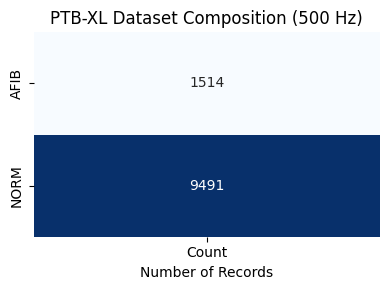

In [38]:
dataset_root = "../data/"

meta = load_ptbxl_metadata(dataset_root)
records = scan_records500(dataset_root, meta)
afib_records = [r for r in records if r["label"] == 1]
norm_records = [r for r in records if r["label"] == 0]

print(f"AFIB records  : {len(afib_records)}")
print(f"NORM records  : {len(norm_records)}")
composition_df = pd.DataFrame({
    "Class": ["AFIB", "NORM"],
    "Count": [len(afib_records), len(norm_records)]
    })

composition_df



plt.figure(figsize=(4, 3))

sns.heatmap(
    composition_df.set_index("Class"),
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False
)

plt.title("PTB-XL Dataset Composition (500 Hz)")
plt.ylabel("")
plt.xlabel("Number of Records")
plt.tight_layout()
plt.show()
